#Content

* Introduction
* Business Problem
* Data Acquisition
* Data Cleaning
* Exploratory Data Analysis
* Data Preprocessing
* Predictive ML Modeling
* Results and Discussion


#Introduction

E-commerce has exploded like never before, resulting in a more fierce competition among online businesses. Competition, Order Fulfillment and Customer Experience are the top challenges facing e-commerce businesses today. It’s all about the conversion – and data integration.

To successfully compete retailers must stay on top of their vast data volumes, including everything from digital images, to customer pricing and invoicing, to marketing and promotions. The explosion of digital technology and big data has changed the game for e-commerce marketers, and data-driven marketing is now a necessity for online retailers who want to retain their competitive edge.


#Business Problem

This real life Europe based **E-Commerce Retailer** is in a competitive business of selling distinctive gifts and presents for occasions and celebrations. Most of the online retailers customers are wholesalers. It's important for the business to retain its competitive advantage over its peers with data driven solutions that give it an edge more so today than ever before, while the world reels in a pandemic. 

Can the retailer's **invoice data** provide insights into any of the subjects listed below?

* Segment a product into cetegories to enable improved product sales
* Segment a customer into categories to enable targeted digital marketing strategies


Additionally, Below topics will also be optionally explored -

* Product sales trends for customer categories
* Customer product preferences based on Geography
* Geographic customer money expenditure trends
* Seasonal Sales increases and decreases
* Time of the day when sales are the most



In [1]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"sriramreddy6","key":"1ed8539f6568470b0ed2ae32954630ba"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d carrie1/ecommerce-data
!unzip \*.zip

     |████████████████████████████████| 122kB 5.3MB/s 
ERROR: pyppeteer 0.2.2 has requirement urllib3<2.0.0,>=1.25.8, but you'll have urllib3 1.24.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
kaggle.json
ecommerce-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ecommerce-data.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Data acquisition

The European E-Commerce retailer's real life data is an intercontinental data set which contains all sales invoices occurring between 2010 and 2012. The data set contains a modest 8 attributes that contain the sales details for the retailer from various geographies. The features in the dataset are -

* InvoiceNo (examples: 936365, 9363656, 936367, 9363658)
* StockCode (examples: 34564D, 345754F, 567557H, 85123A)
* Description (examples : WOOD S/43 CABINET ANT FINISH, PINK GIRLY TOOL SET, SET OF 6 FUNKY BEAKERS)
* Quantity (examples: 5,10,30,100)
* InvoiceDate (examples: 11/1/2010 9:53, 12/2/2010 9:59, 12/3/2010 9:59)
* UnitPrice (examples: 4.95, 3.29,15.95, 8.99)
* CustomerID (examples: 137850 , 778546, 556455, 787853 )
* Country (examples: India, Nepal, Sri Lanka, Bhutan)
The scope to analyze this dataset is substantial and can cover areas such as time series trends, customer clustering, classification and more.

For the Capstone project we will limit the analysis to Customer Segmentation and Purchase Prediction. It remains to be seen which of these classification model best serves in distinguishing the customers into various segments - Logistic Regression, Support Vector Machine, k-Nearest Neighbors, Decision Tree, or if any of the cutting edge models such as Gradient Boosting Trees, AdaBoost Classifier, or Deep Learning will provide boosted accuracies.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import random 
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
import datetime as dt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

color = sns.color_palette()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str}) 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


#Data Cleaning

In [5]:
print('Dataframe dimensions:', df.shape)
print(' ')
print(' ')
print(" \nCount total NaN at each column in a DataFrame : \n\n", df.isnull().sum()) 
print(' ')
print(' ')
print('Duplicate entrees: {}'.format(df.duplicated().sum()))
print(' ')
print(' ')


Dataframe dimensions: (541909, 8)
 
 
 
Count total NaN at each column in a DataFrame : 

 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
 
 
Duplicate entrees: 5268
 
 


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#delete duplicate entrees
df.drop_duplicates(inplace = True)

# since customer IDs are missing, we can delete this data as it cannot be imputed. 
df = df.dropna(subset=["CustomerID"])

df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] )

dfm = df

le = LabelEncoder()
le.fit(dfm['Country'])
dfm['Country'] = le.transform(dfm['Country'])

#Exploratory Data Analysis


###**Countries from which orders were placed : CHOROPLETH MAP**

View the orders trends from different countries.

In [7]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### **Countries from which orders are placed**

View the countries which drive the most traffic and sales to the ecommerice site.

In [8]:
print('Count of unique Counties: ', df.Country.nunique())
print(' ')
print(' ')


Count of unique Counties:  37
 
 


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



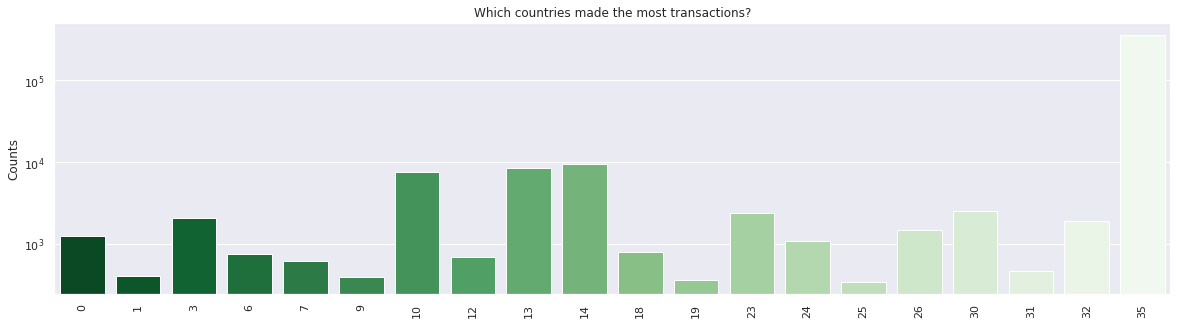

In [9]:
country_counts = df.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

###**Customer trends**

Money Spent by different Customers

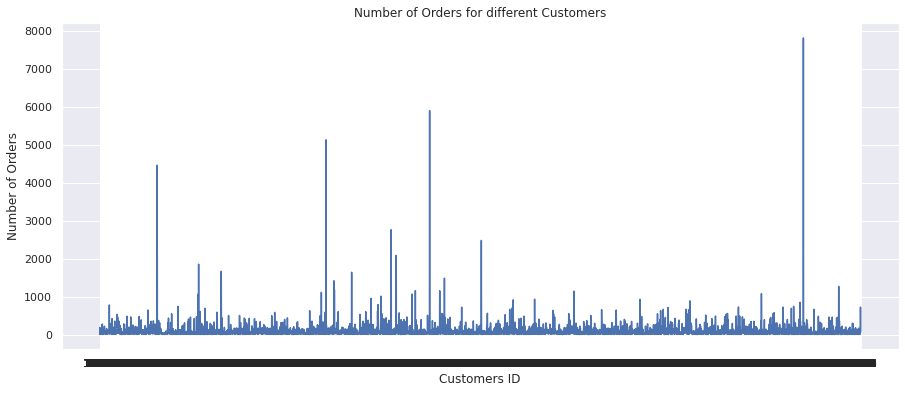

In [10]:
orders = df.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

###**Stockcode frequency**

Visualize the frequent Stockcodes purchased by customers.

In [11]:
print('Count of unique Stock Codes: ', df.StockCode.nunique())
print(' ')
print(' ')


Count of unique Stock Codes:  3684
 
 


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



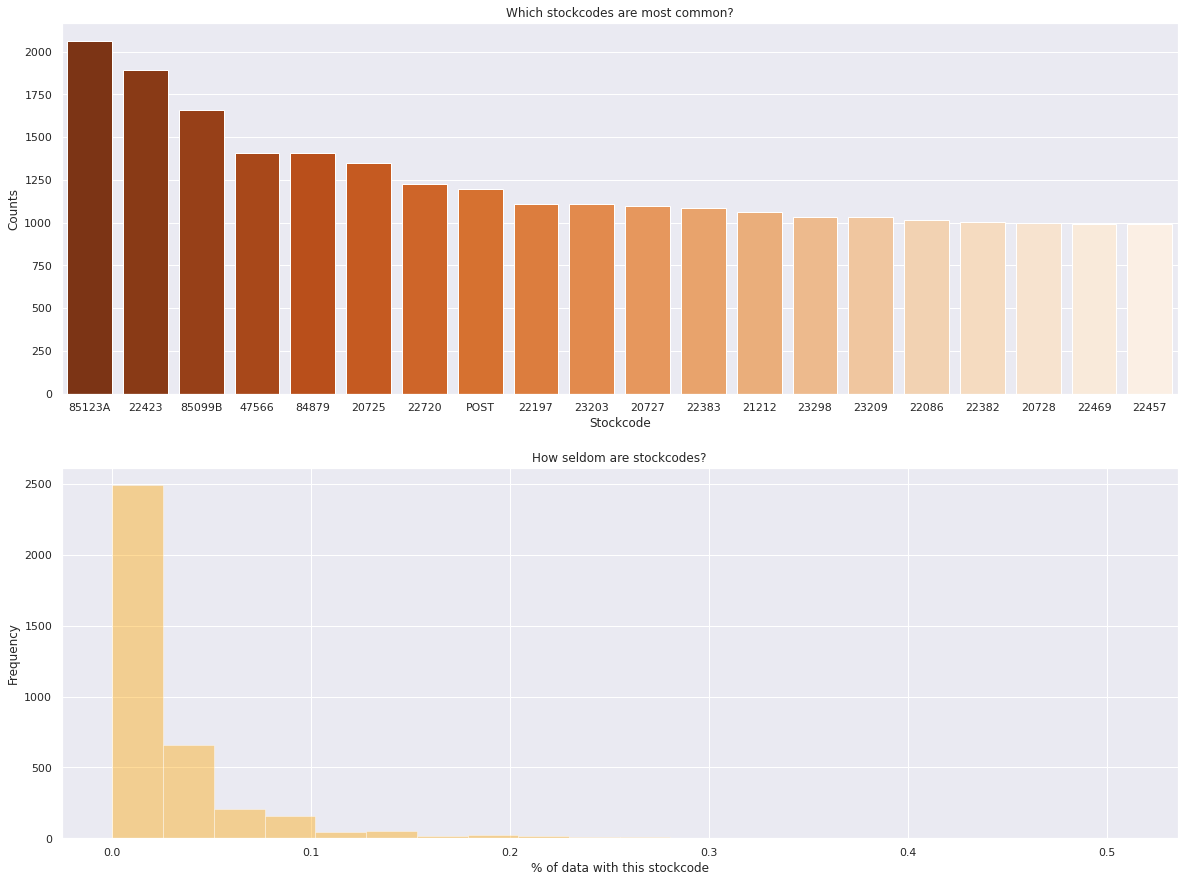

In [12]:

stockcode_counts = df.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/df.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

###**Product Description Frequency**

Visualize popular products among customers.

In [13]:
print('Count of unique Descriptions: ', df.Description.nunique())
print(' ')
print(' ')


Count of unique Descriptions:  3896
 
 


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



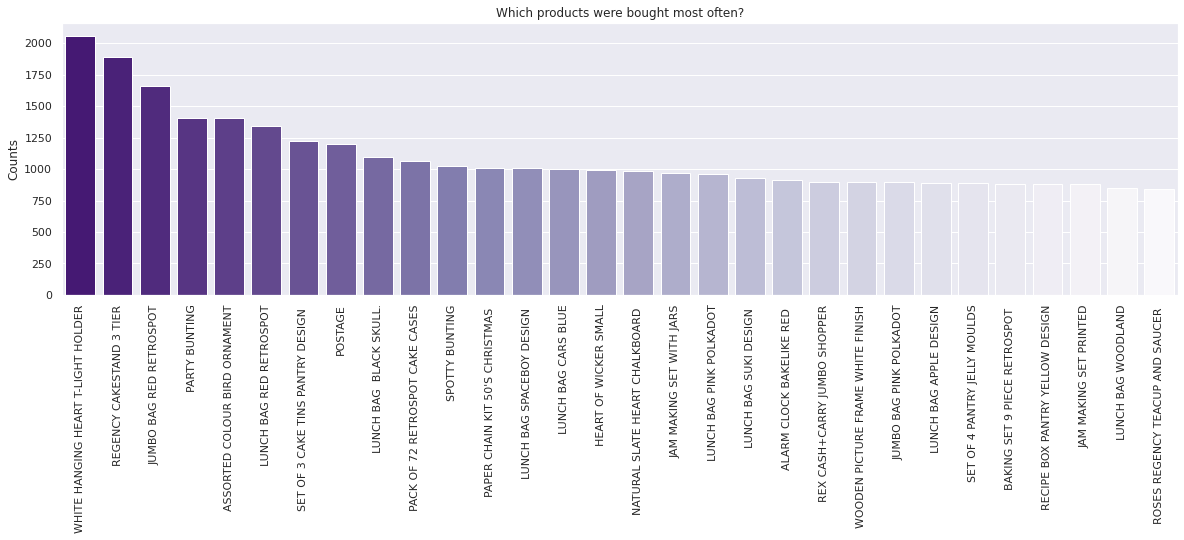

In [14]:
description_counts = df.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which products were bought most often?");
plt.xticks(rotation=90);

###**Customer Frequency**

View the customers who are most loyal.

In [15]:
print('Count of unique Customers: ', df.CustomerID.nunique())
print(' ')
print(' ')


Count of unique Customers:  4372
 
 


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



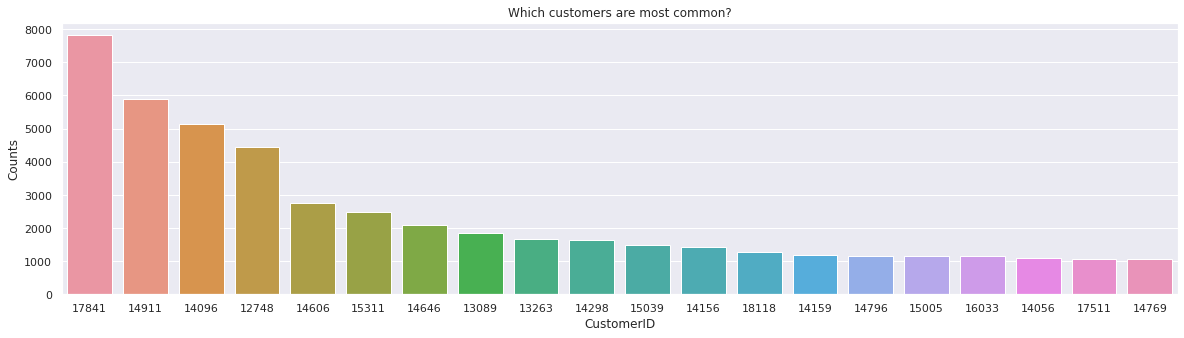

In [16]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

In [17]:
df.insert(loc=2, column='year_month', value=df['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df.insert(loc=3, column='month', value=df.InvoiceDate.dt.month)
# +1 to make Monday=1.....until Sunday=7
df.insert(loc=4, column='day', value=(df.InvoiceDate.dt.dayofweek)+1)
df.insert(loc=5, column='hour', value=df.InvoiceDate.dt.hour)
df.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,201012,12,3,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,15.30
1,536365,71053,201012,12,3,8,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,20.34
2,536365,84406B,201012,12,3,8,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,22.00
3,536365,84029G,201012,12,3,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,20.34
4,536365,84029E,201012,12,3,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,20.34


###**Invoice analysis**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



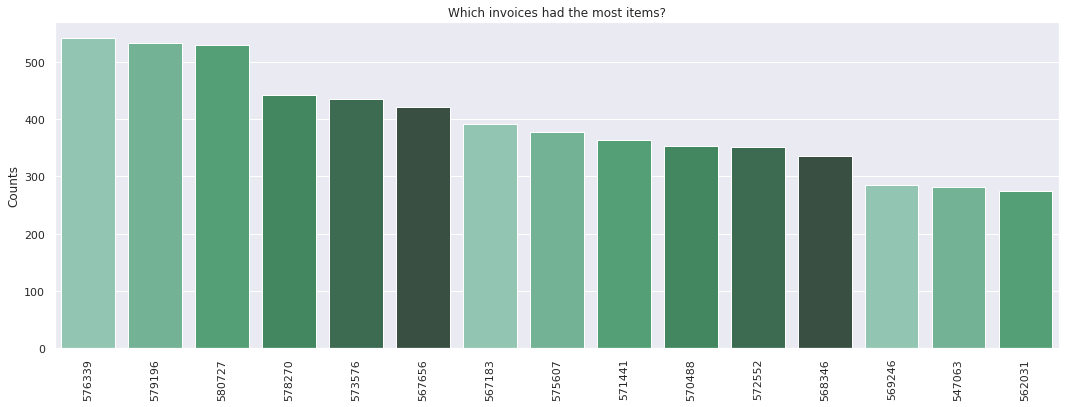

In [18]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(inv_counts.index, inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

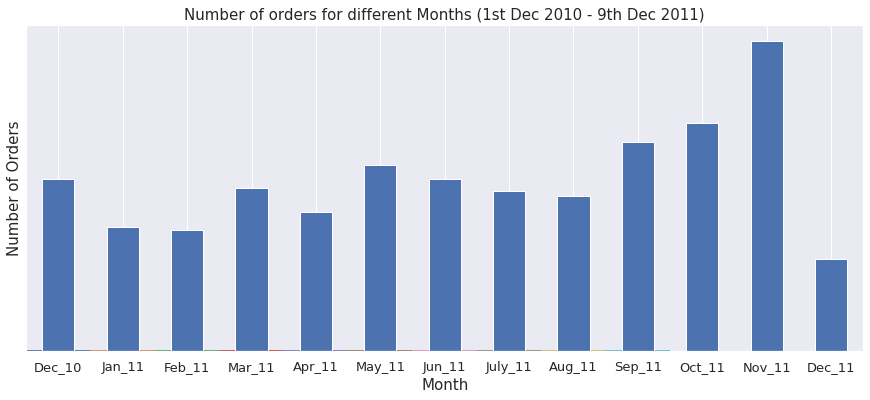

In [19]:
sns.palplot(color)

ax = df.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
ax.invert_yaxis()
plt.show()

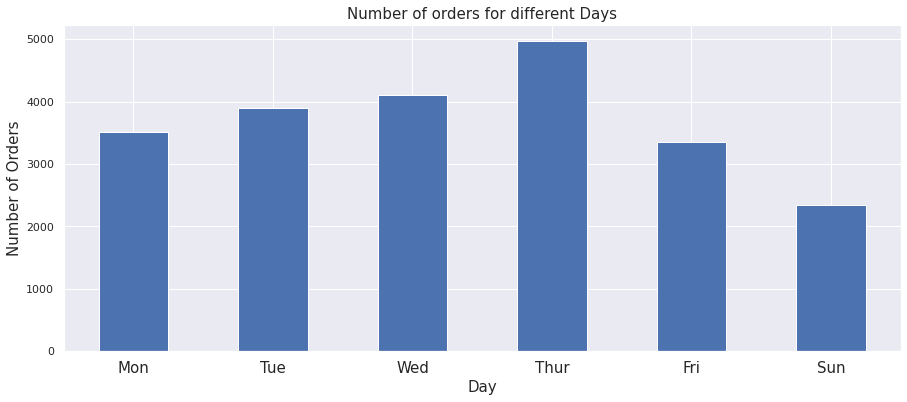

In [20]:
ax = df.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

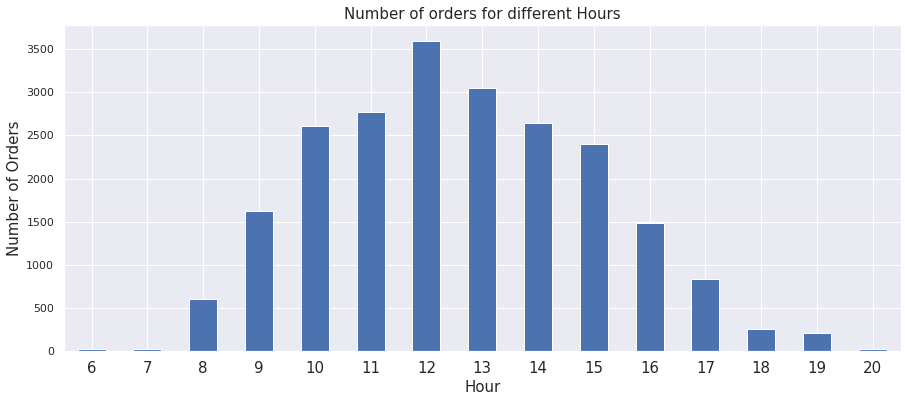

In [21]:
ax = df.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

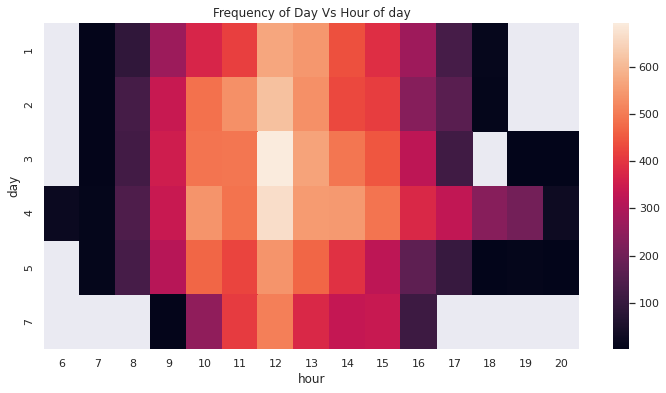

In [22]:
grouped_df  = df.groupby(["day", "hour"])["InvoiceNo"].unique().reset_index()
grouped_df["InvoiceNo"] = grouped_df["InvoiceNo"].apply(len)

#grouped_df = df.groupby(["Weekday", "hour"])["InvoiceNo"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'InvoiceNo')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day Vs Hour of day")
plt.show()

# Data Preprocessing

In [23]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0



entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [24]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [25]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,QuantityCanceled
77598,C542742,84535B,201101,1,1,16,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,35,-61.10,0
90444,C544038,22784,201102,2,2,11,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,35,-19.80,0
111968,C545852,22464,201103,3,1,13,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,35,-8.25,0
116064,C546191,47566B,201103,3,4,10,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,35,-24.50,0
132642,C547675,22263,201103,3,4,14,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,35,-32.34,0


In [26]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [27]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

In [28]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
NOW = dt.datetime(2011,12,10)

In [29]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [30]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [31]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [32]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [33]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head(5)

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,QuantityCanceled
9754,537215,85124C,201012,12,7,15,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,30.60,0
9755,537215,85124B,201012,12,7,15,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,15.30,0
9756,537215,84879,201012,12,7,15,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,27.04,0
9757,537215,85062,201012,12,7,15,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,39.60,0
9758,537215,85064,201012,12,7,15,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,32.70,0


In [34]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [35]:
segmented_rfm = rfmTable_final

In [36]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [37]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1797.24,3,2,1
12349,18.0,18.0,1,1757.55,2,4,1
12350,310.0,310.0,1,334.40,4,4,3


In [38]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1797.24,3,2,1,321
12349,18.0,18.0,1,1757.55,2,4,1,241
12350,310.0,310.0,1,334.40,4,4,3,443


In [39]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,75,279558.62,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,47,193332.83,1,1,1,111
14911,1.0,373.0,202,136140.74,1,1,1,111
14156,9.0,371.0,55,114370.20,1,1,1,111
...,...,...,...,...,...,...,...,...
16115,9.0,292.0,8,1660.88,1,1,1,111
16813,8.0,204.0,10,1652.18,1,1,1,111
15953,15.0,369.0,8,1651.33,1,1,1,111


In [40]:
segmented_rfm = segmented_rfm.reset_index()

In [41]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [42]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

In [43]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [44]:
df_cleaned['Month'].value_counts()

11    63194
10    48799
12    42708
9     39678
5     28082
6     26933
3     26877
8     26810
7     26587
4     22438
1     20992
2     19711
Name: Month, dtype: int64

In [45]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

# Predictive ML Modeling

###**Clustering Products into Categories**

In [46]:
#df_x["Description"] = df["Description"].dropna()
X = df_cleaned["Description"].unique()


stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3878, 1698) of float64


In [47]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3878, 100) of float64


In [48]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

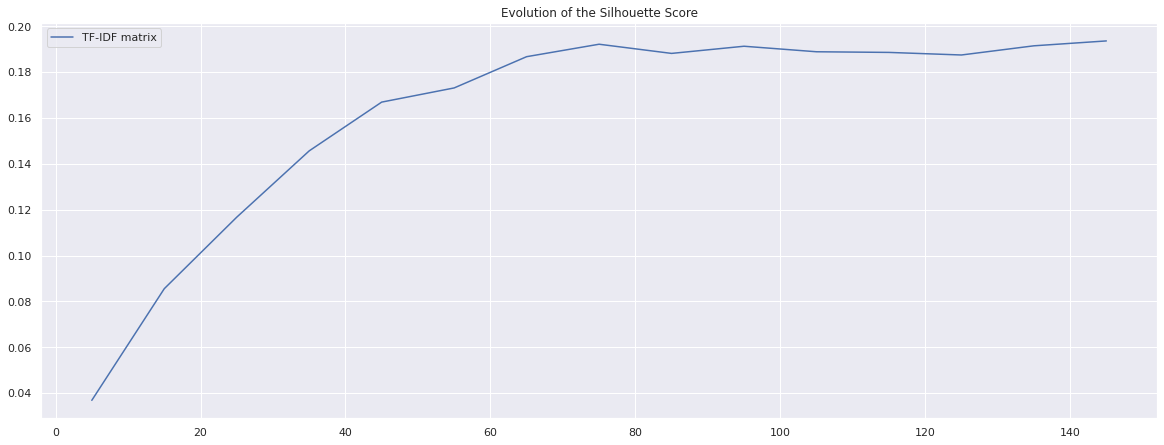

In [49]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()



Best performance was at n_clusters = 135



Text(0.5, 1.0, 'ACP with 135 clusters')

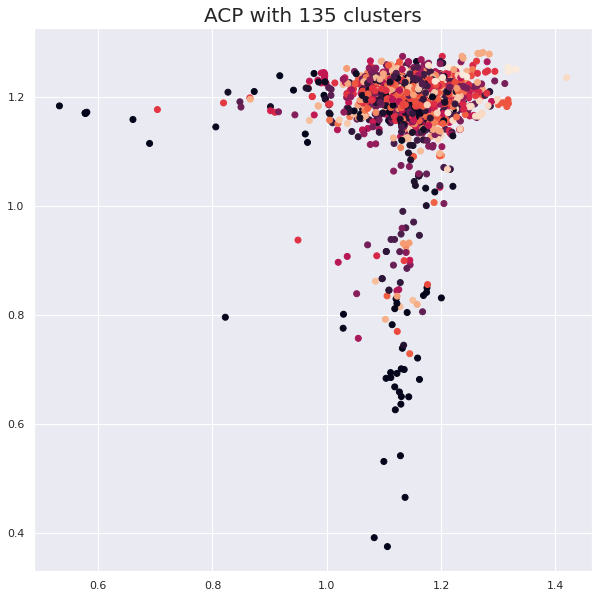

In [50]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

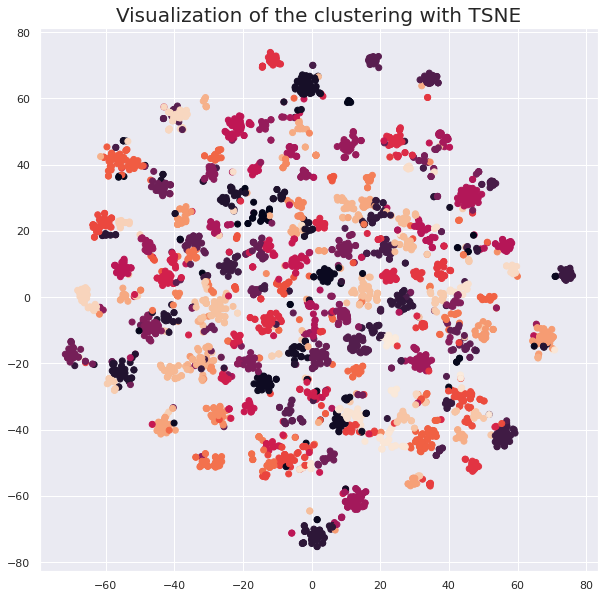

In [51]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

Word Cloud of most popular product description keywords among the product clusters

<Figure size 432x288 with 0 Axes>

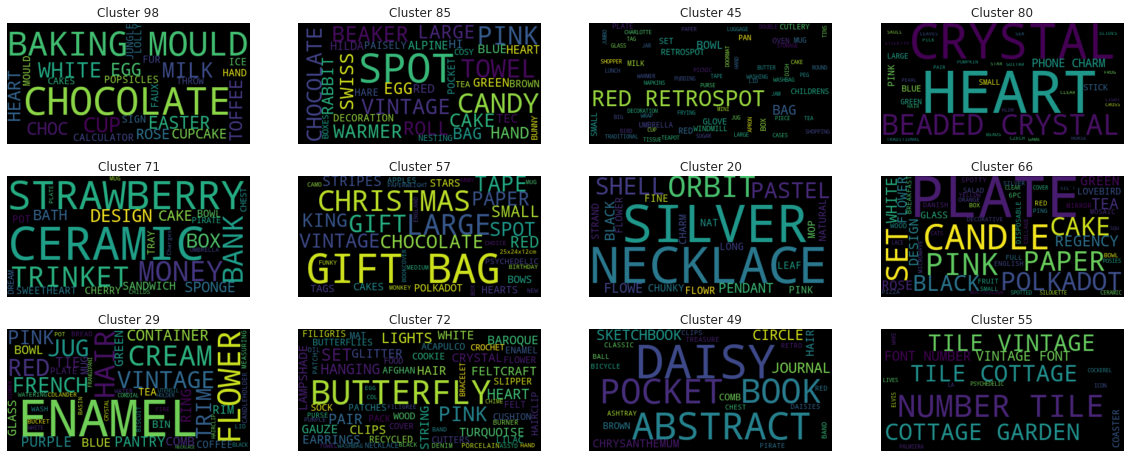

<Figure size 432x288 with 0 Axes>

In [52]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()


In [53]:
df.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,201012,12,3,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,15.30
1,536365,71053,201012,12,3,8,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,20.34
2,536365,84406B,201012,12,3,8,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,22.00
3,536365,84029G,201012,12,3,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,20.34
4,536365,84029E,201012,12,3,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,20.34


###**Customer Segmentation** 



Clustering columns

In [54]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [55]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [56]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [57]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [58]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [59]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [60]:
X1 = df_grouped_final.values
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [61]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8555585912881648 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8798143004757907 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.28515839620550554 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.2967590972296624 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.3920803670110533 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4005138366014912 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.40283214635972536 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.39969959818523726 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.41437735349454496 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.4005743125601105 with Std Scaling


We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here.

In [62]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

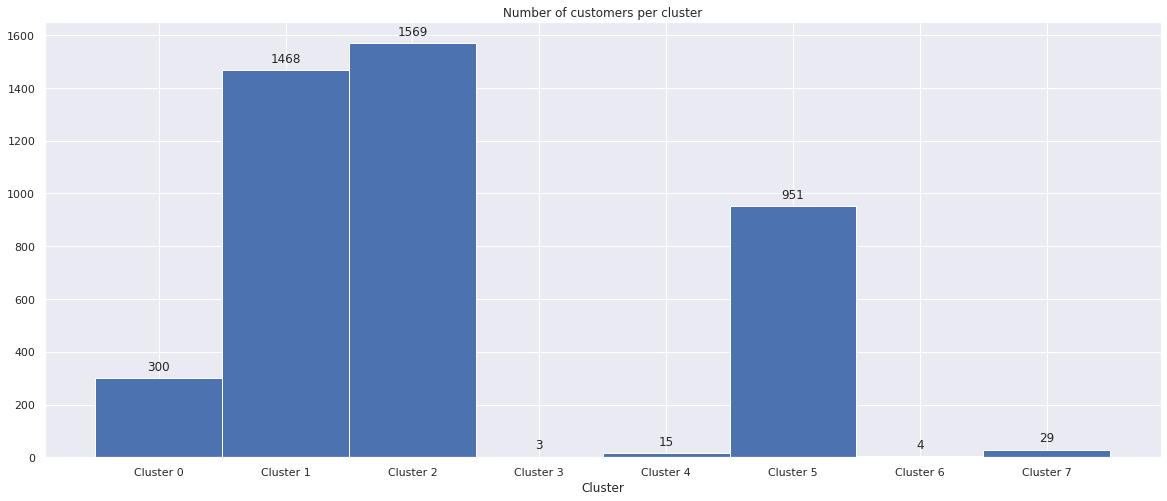

In [63]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [64]:
df_grouped_final["cluster"] = clusters

In [65]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104,Cluster_105,Cluster_106,Cluster_107,Cluster_108,Cluster_109,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,7,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0000,0.000000,0.0,0.000000
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,0,0.0,0.046775,0.0,0.0,0.0,0.044374,0.00877,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.002923,0.0,0.057912,0.0,0.002715,0.000000,0.020589,0.0,0.004037,0.0,0.0,0.0,0.000000,...,0.093828,0.001392,0.002506,0.004594,0.000000,0.010970,0.0,0.044353,0.006125,0.0,0.0,0.000000,0.008701,0.0,0.000000,0.0,0.000000,0.006961,0.002367,0.000000,0.0,0.030626,0.00348,0.0,0.023596,0.0,0.0,0.018376,0.000000,0.000000,0.0,0.018759,0.018376,0.00348,0.0,0.0,0.0000,0.003081,0.0,0.000000
12348,39.6,150.0,82.840000,75.0,358.0,4,1797.24,2341,12,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.322717,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.096815,0.000000,0.000000,0.009459,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.035388,0.0,0.000000,0.116712,0.00000,0.0,0.0,0.0000,0.000000,0.0,0.000000
12349,15.0,15.0,15.000000,18.0,18.0,1,1757.55,631,18,0,0.0,0.000000,0.0,0.0,0.0,0.007254,0.00000,0.0,0.0,0.0,0.0,0.056328,0.009559,0.040113,0.0,0.0,0.0,0.022731,0.0,0.000000,0.0,0.000000,0.036301,0.000000,0.0,0.022133,0.0,0.0,0.0,0.018435,...,0.000000,0.000000,0.000000,0.000000,0.010071,0.021251,0.0,0.039487,0.008535,0.0,0.0,0.021621,0.000000,0.0,0.007101,0.0,0.004438,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.010071,0.0,0.0,0.019715,0.010173,0.000000,0.0,0.033023,0.000000,0.00000,0.0,0.0,0.0198,0.000000,0.0,0.011323
12350,25.2,25.2,25.200000,310.0,310.0,1,334.40,197,24,5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.118421,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.059211,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.044856,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.044856,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0000,0.000000,0.0,0.000000


In [66]:
final_dataset_V2 = final_dataset.reset_index()

In [67]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

###**Interpreting the clusters**

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

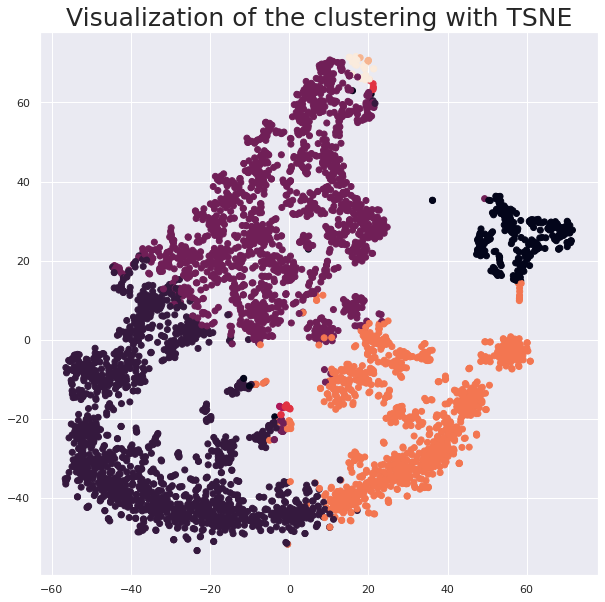

In [68]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

Graphically the clusters are distinctive enough.
Let's take a closer look at the clusters that contain few customers.

#Results and Discussion

### **Cluster 0**


In [69]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104,Cluster_105,Cluster_106,Cluster_107,Cluster_108,Cluster_109,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,13.20,45.00,23.308571,2.0,367.0,7,4310.00,2458,16,0,0.000000,0.046775,0.0,0.0,0.000000,0.044374,0.00877,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.002923,0.000000,0.057912,0.0,0.002715,0.000000,0.020589,0.000000,0.004037,0.0,0.0,0.0,0.000000,...,0.093828,0.001392,0.002506,0.004594,0.000000,0.010970,0.000000,0.044353,0.006125,0.0,0.00000,0.000000,0.008701,0.0,0.000000,0.0,0.000000,0.006961,0.002367,0.000000,0.000000,0.030626,0.003480,0.000000,0.023596,0.0,0.0,0.018376,0.000000,0.000000,0.000000,0.018759,0.018376,0.00348,0.0,0.000000,0.000000,0.003081,0.0,0.000000
12348,39.60,150.00,82.840000,75.0,358.0,4,1797.24,2341,12,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.322717,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.096815,0.000000,0.000000,0.009459,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.035388,0.000000,0.000000,0.116712,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
12349,15.00,15.00,15.000000,18.0,18.0,1,1757.55,631,18,0,0.000000,0.000000,0.0,0.0,0.000000,0.007254,0.00000,0.0,0.000000,0.000000,0.0,0.056328,0.009559,0.040113,0.000000,0.000000,0.0,0.022731,0.000000,0.000000,0.0,0.000000,0.036301,0.000000,0.000000,0.022133,0.0,0.0,0.0,0.018435,...,0.000000,0.000000,0.000000,0.000000,0.010071,0.021251,0.000000,0.039487,0.008535,0.0,0.00000,0.021621,0.000000,0.0,0.007101,0.0,0.004438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010071,0.0,0.0,0.019715,0.010173,0.000000,0.000000,0.033023,0.000000,0.00000,0.0,0.000000,0.019800,0.000000,0.0,0.011323
12353,19.90,19.90,19.900000,204.0,204.0,1,89.00,20,2,0,0.000000,0.000000,0.0,0.0,0.000000,0.801124,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
12355,30.00,30.00,30.000000,214.0,214.0,1,459.40,240,2,0,0.000000,0.115586,0.0,0.0,0.000000,0.098825,0.00000,0.0,0.000000,0.000000,0.0,0.065303,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.424467,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0

In [70]:
final_dataset[final_dataset['cluster']==0].mean()

min             10.272800
max             91.632200
mean            41.042297
min_recency     91.563333
max_recency    222.056667
                  ...    
Cluster_130      0.003463
Cluster_131      0.007841
Cluster_132      0.002827
Cluster_133      0.000026
Cluster_134      0.004674
Length: 145, dtype: float64

In [71]:
temp_final_df = final_dataset.reset_index()

In [72]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [73]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              13.792400
UnitPrice              4.101597
QuantityCanceled       0.152590
TotalPrice            25.465065
frequency              8.164951
min_recency           45.954052
monetary_value      4933.787317
dtype: float64

In [74]:
cluster0['Description'].value_counts()[:10]

POSTAGE                                875
ROUND SNACK BOXES SET OF4 WOODLAND     235
REGENCY CAKESTAND 3 TIER               164
PLASTERS IN TIN WOODLAND ANIMALS       154
ROUND SNACK BOXES SET OF 4 FRUITS      148
RED TOADSTOOL LED NIGHT LIGHT          146
PLASTERS IN TIN CIRCUS PARADE          146
SPACEBOY LUNCH BOX                     138
RABBIT NIGHT LIGHT                     123
PLASTERS IN TIN SPACEBOY               123
Name: Description, dtype: int64

In [75]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [76]:
cluster0_grouped['RFMScore'].value_counts()

111    32
211    22
444    22
443    19
322    17
221    14
343    12
122    11
332    10
121    10
321     8
342     7
233     6
244     6
132     5
344     5
144     5
243     5
442     5
222     5
431     5
433     5
333     4
432     4
331     4
133     4
421     4
441     4
242     3
423     3
334     3
323     3
223     3
123     3
231     3
311     3
143     2
232     2
212     2
234     2
112     2
142     2
241     1
341     1
324     1
422     1
Name: RFMScore, dtype: int64

In [77]:
cluster0_grouped['Country'].value_counts()

14    94
13    87
3     24
18    12
12    12
6      9
1      9
9      8
0      8
7      7
19     6
15     4
5      4
23     3
17     3
2      2
22     2
4      1
24     1
8      1
10     1
16     1
11     1
Name: Country, dtype: int64

In [78]:
cluster0['Month'].value_counts()

11    3449
10    3237
9     2276
8     2225
12    2176
6     2051
3     1988
5     1869
7     1824
1     1801
2     1200
4     1063
Name: Month, dtype: int64

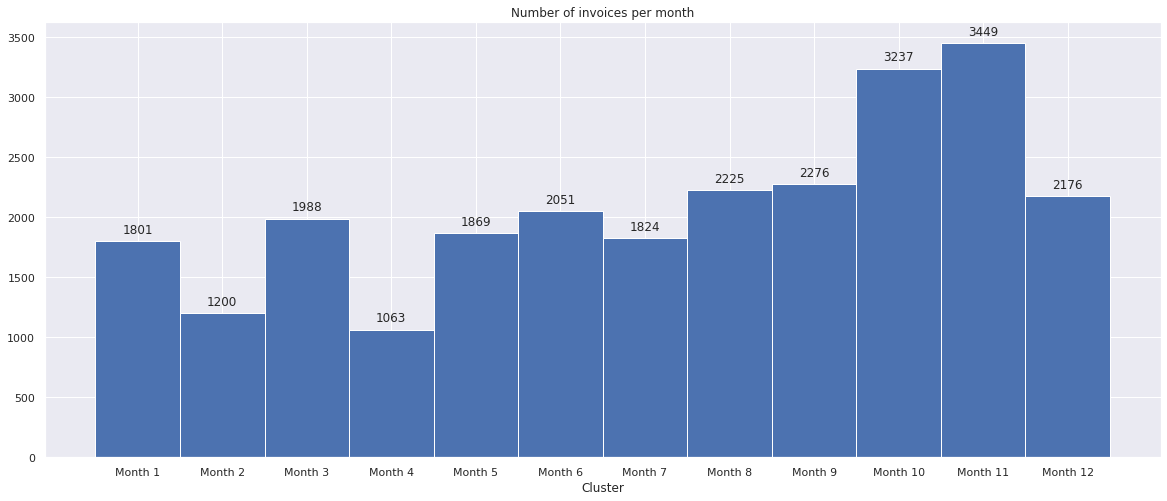

In [79]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [80]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    58
2011.0    32
Name: Year, dtype: int64

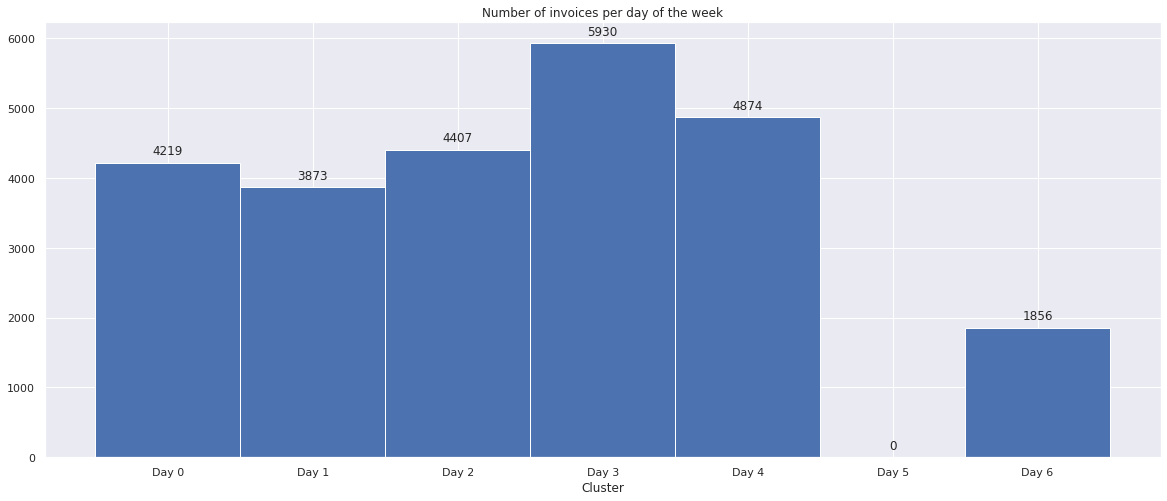

In [81]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [82]:
cluster0['Day'].nunique()

31

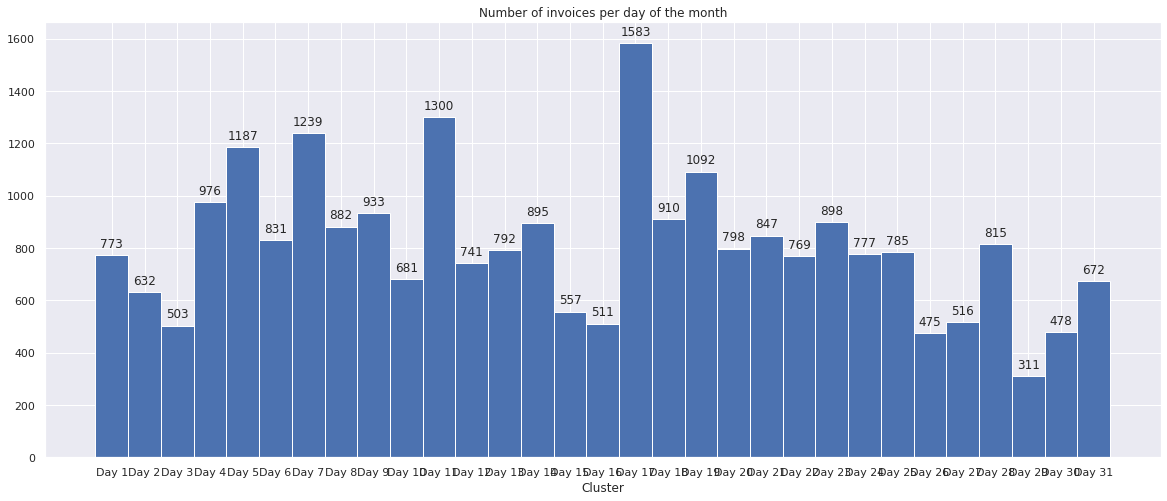

In [83]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [84]:
cluster0['Hour'].nunique()

13

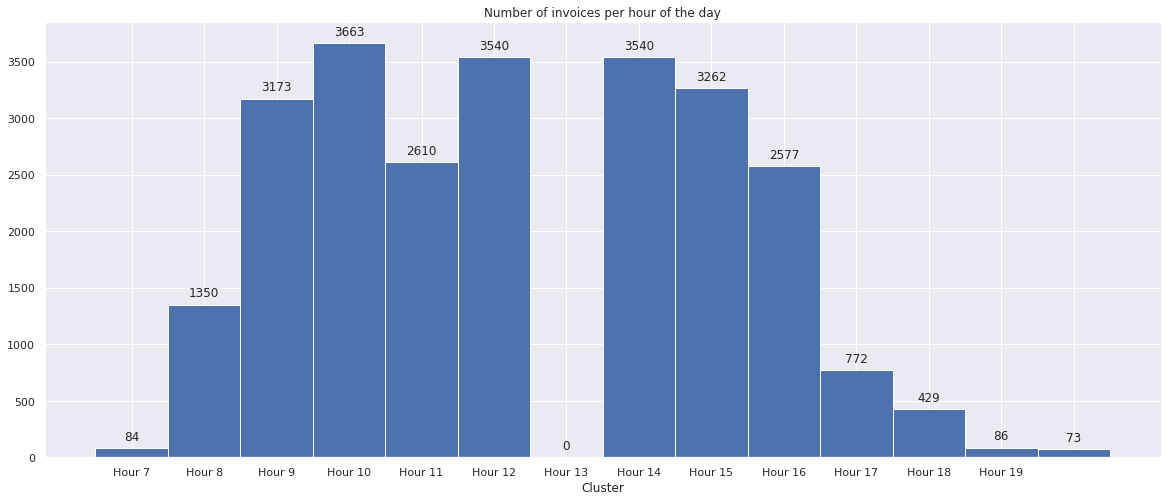

In [85]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

These customers seems to be good since they have good RFM scores, the 4 most represented categories are (111, 211, 322, 222). They seem to be normal customers. 


Key figures: 
* Min Basket Price: 10.86
* Mean Basket Price: 30.60
* Max Basket Price: 68.57

* Quantity:            10.00
* UnitPrice:           2.87
* QuantityCanceled:     0.04
* TotalPrice:           17.09
* Frequency           11.134050
* Recency         24.574626

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER:    1345
* JUMBO BAG RED RETROSPOT:               1079
* REGENCY CAKESTAND 3 TIER:               960
* ASSORTED COLOUR BIRD ORNAMENT:          926
* PARTY BUNTING:                          924
* LUNCH BAG RED RETROSPOT:                898
* LUNCH BAG  BLACK SKULL:                753
* SET OF 3 CAKE TINS PANTRY DESIGN:       725
* LUNCH BAG CARS BLUE:                    679
* LUNCH BAG PINK POLKADOT:                676

###Results : Analysis of remaining clusters

###**Cluster 1**

I already have done all the same analysis for the other clusters, so I won't put all of the code here but the idea is the same

This cluster represents almost lost customers. The weird part about them is that there are some months when they didn't shop at all, it looks like a pattern. 


Key figures: 
* Min Basket Price: 20.83
* Mean Basket Price: 33.77
* Max Basket Price: 26.43

* Quantity:            9.06
* UnitPrice:           2.68
* QuantityCanceled:     0.02
* TotalPrice:           13.77
* Frequency            3.065758
* Recency         36.131902

TOP 10 bought products :

* PAPER CHAIN KIT 50'S CHRISTMAS:        267
* BAKING SET 9 PIECE RETROSPOT:          263
* WHITE HANGING HEART T-LIGHT HOLDER:    250
* ASSORTED COLOUR BIRD ORNAMENT:         247
* REX CASH+CARRY JUMBO SHOPPER:          223
* HOT WATER BOTTLE KEEP CALM:            215
* REGENCY CAKESTAND 3 TIER:              208
* RABBIT NIGHT LIGHT:                    200
* GARDENERS KNEELING PAD KEEP CALM:      194
* SPOTTY BUNTING:                        193

###**Cluster 2**

The cluster 2 represents the best customers with a high recency which have around 60 visits, a lot of quantity bought on average, a high moneraty value and also a high frequency around 60 visits. These customers must be taken care.
* Min Basket Price : 13
* Mean Basket Price : 513
* Max Basket Price : 3812
* Quantity            117.083422
* UnitPrice             2.830180
* QuantityCanceled      0.069282
* TotalPrice          258.683970
* frequency            67.812655
* min_recency           1.679039

###**Cluster 3**

This cluster is full of lost customers. Indeed, as we can see in the month histogramm there are almost no invoices after july. We can see that there are in december but it's december of the past year. So this cluster is pretty bad, they don't want to have new customers in there. Furthermore they are cheap customers since the mean basket price is 28.91$.



Key figures: 
* Min Basket Price: 24.20
* Mean Basket Price: 28.91
* Max Basket Price: 34.52

* Quantity:            8.25
* UnitPrice:           3.29
* QuantityCanceled:     0.04
* TotalPrice:          15.20
* Frequency             2.606359
* Recency         237.013433

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER:    227
* REGENCY CAKESTAND 3 TIER:              182
* PARTY BUNTING:                         137
* ASSORTED COLOUR BIRD ORNAMENT:         125
* REX CASH+CARRY JUMBO SHOPPER:          103
* SET OF 3 CAKE TINS PANTRY DESIGN:      100
* NATURAL SLATE HEART CHALKBOARD:        100
* JAM MAKING SET WITH JARS:               99
* HEART OF WICKER SMALL:                  98
* HEART OF WICKER LARGE:                  86

###**Cluster 4**

This cluster is quiete heterogeneous since there are 17 best customers, 6 lost cheap customers and so on. They do have a high mean basket price of 505 but it's mostly due to the mean quantity they buy (130) because the mean unit price is very low (3.26)

For the time features, what is interesting is that these customers shop less on weekend and they shopped more at the end of the year.

* Min Basket Price : 247
* Mean Basket Price : 505
* Max Basket Price : 1023
* Quantity            130.299145
* UnitPrice             3.264359
* QuantityCanceled      2.332590
* TotalPrice          184.308595

TOP 10 products bought :

* JUMBO BAG RED RETROSPOT :               38
* BLACK RECORD COVER FRAME :            31
* RECORD FRAME 7" SINGLE SIZE :         28
* REGENCY CAKESTAND 3 TIER :           25
* WORLD WAR 2 GLIDERS ASSTD DESIGNS :    24
* WHITE HANGING HEART T-LIGHT HOLDER :   24
* PARTY BUNTING :                        24
* LUNCH BOX I LOVE LONDON :               23
* RED  HARMONICA IN BOX :                23
* CHILLI LIGHTS :                        23

###**Cluster 5**

The cluster 5 contains 3 customers which are very much alike. Indeed, they bought only once or twice a few items at a huge quantity. It might be some profesionnals which bought it at discount and will sell back the commodity. Even if they have a high monetary value they're not very interesting and we could consider them as lost customers.
* Min Basket Price : 3368
* Mean Basket Price : 3697
* Max Basket Price : 3533
* Quantity            2213.777778
* UnitPrice              2.386667
* QuantityCanceled       0.000000
* TotalPrice          3890.091111
* Frequency              1.666667
* Min_recency          210.888889

###**Cluster 6**

What is very specific about this cluster is that there are no customers from UK, it's only foreign countries (Germany, France, Belgium, Italy and Finland).
This cluster is also heterogeneous in terms of RFM since the 2 most represented categories are Best customer and Lost cheap customer. The average basket is very low (33) comparing the ones above but I guess that the more customers we have in a cluster and the more the average customer will be represented which doesn't spent 500$ per transactions like the ones above. 

October and november have the most invoices which isn't surpring approaching Christmas. 

Key figures: 
* Min Basket Price: 20.58
* Mean Basket Price: 33.55
* Max Basket Price: 59.31

* Quantity:            13.785663
* UnitPrice:           2.884687
* QuantityCanceled:     0.057975
* TotalPrice:          23.749951
* Frequency            7.865563
* Recency         46.622343

TOP 10 bought products :

* ROUND SNACK BOXES SET OF4 WOODLAND:     233
* REGENCY CAKESTAND 3 TIER:               161
* PLASTERS IN TIN WOODLAND ANIMALS:       150
* ROUND SNACK BOXES SET OF 4 FRUITS:      146
* RED TOADSTOOL LED NIGHT LIGHT:          144
* PLASTERS IN TIN CIRCUS PARADE:          141
* SPACEBOY LUNCH BOX:                     137
* RABBIT NIGHT LIGHT:                     120
* PLASTERS IN TIN SPACEBOY:               120
* WOODLAND CHARLOTTE BAG:                 111

###**Cluster 7**

The cluster 7 contains 19 customers who are considered as best customers since they by the most, very frequently (75) and recently. The difference with cluster 2 is that they cluster 7's customers buy more frequently (75 vs 60) but have a lower monetary value (58000 vs 249000).
They have a mean basket price lower than the other clusters.

* Min Basket Price : 10
* Mean Basket Price : 138
* Max Basket Price : 648
* Quantity            23.257769
* UnitPrice            2.615444
* QuantityCanceled     0.109129
* TotalPrice          34.916436
* Frequency           121.570291
* Recency           2.599109

TOP 10 products bought :

* REGENCY CAKESTAND 3 TIER:              136
* JUMBO BAG RED RETROSPOT:               135
* WHITE HANGING HEART T-LIGHT HOLDER:    121
* CHILLI LIGHTS:                         102
* PAPER BUNTING RETROSPOT:                97
* LUNCH BAG  BLACK SKULL:                95
* GUMBALL COAT RACK:                      93
* LUNCH BAG RED RETROSPOT:                91
* JUMBO BAG PINK POLKADOT:                84
* LUNCH BAG CARS BLUE:                    81

#Conclusion

Let's quickly classify the clusters in terms of importance :

###Cluster 2: 
High frequency with a lot of quantity (mean basket price of 513) bought on average and high monetary value (VIP clients)

* The cluster 2 represents the best customers with a high recency which have around 60 visits, a lot of quantity bought on average, a high moneraty value and also a high frequency around 60 visits. 
* These customers must be taken care.

###Cluster 7 : 
Very high purchase frequency with a mean basket price of 150 but good monetary value.
* The cluster 7 contains 19 customers who are considered as best customers since they by the most, very frequently (75) and recently. 
* The difference with cluster 2 is that they cluster 7's customers buy more frequently (75 vs 60) but have a lower monetary value (58000 vs 249000). 
* They have a mean basket price lower than the other clusters.

###Cluster 4: 
Very high basket price (huge quantity of products bought on average)

* This cluster is quiete heterogeneous since there are 17 best customers, 6 lost cheap customers and so on. 
* They do have a high mean basket price of 505 but it's mostly due to the mean quantity they buy (130) because the mean unit price is very low (3.26)
* For the time features, what is interesting is that these customers shop less on weekend and they shopped more at the end of the year.

###Cluster 0: 
Good average customers 

* These customers seems to be good since they have good RFM scores, the 4 most represented categories are (111, 211, 322, 222). They seem to be normal customers.

###Cluster 6: 
Good foreign customers 
* What is very specific about this cluster is that there are no customers from UK, it's only foreign countries (Germany, France, Belgium, Italy and Finland). 
* This cluster is also heterogeneous in terms of RFM since the 2 most represented categories are Best customer and Lost cheap customer. 
* The average basket is very low (33) comparing the ones above, but the more customers we have in a cluster and the more the average customer will be represented which doesn't spent 500$ per transactions like the ones above.
* October and november have the most invoices which isn't surpring approaching Christmas.

###Cluster 1: 
This cluster represents almost lost customers. 
* The strange part about them is that there are some months when they didn't shop at all, it looks like a pattern.

###Cluster 5: 
Highest monetary value but only one or two purchases over the year 
* The cluster 5 contains 3 customers which are very much alike. Indeed, they bought only once or twice a few items at a huge quantity. 
* It might be some profesionnals which bought it at discount and will sell back the commodity. 
* Even if they have a high monetary value they're not very interesting and we could consider them as lost customers.

###Cluster 3: 
Lost customers 
* This cluster is full of lost customers. 
* Indeed, as we can see in the month histogramm there are almost no invoices after july. 
* We can see that there are in december but it's december of the past year. * So this cluster is pretty bad, they don't want to have new customers in there. 
* Furthermore they are cheap customers since the mean basket price is 28.91$

 
